In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tacc_stats.analysis.plot.plots import Plot
import numpy
import cPickle as pickle

class NewDevPlot(Plot):
    '''Altered DevPlot object'''
    
    def __init__(self, path, data, type_name, processes=1):
        '''
        :param path [string]: full path to pickle file
        :param data [pickle object]: unloaded piuckle data
        :param type_name [string]: io parameter of interest
        :processes [int]: default process value (do not change)
        :return x_val [array]: time vector in hours
        :return y_val [array]: io data 
        '''
        #Unload pickle data
        self.data = data
        self.path = path
        #Get schema information
        schema = self._build_schema(self.data,type_name)
        schema = [x.split(',')[0] for x in schema]
        #k1 will have a list of type_names of schema length for all keys
        self.k1 = {'intel_snb' : [type_name]*len(schema),
                  'intel_hsw' : [type_name]*len(schema),
                  'intel_pmc3' : [type_name]*len(schema)
                  }
        #k2 will have list generated with build_schema for all keys
        self.k2 = {'intel_snb': schema,
                  'intel_hsw': schema,
                  'intel_pmc3': schema
                  }
        #Initialize object
        super(NewDevPlot,self).__init__(data=data, type_name=type_name,processes=1)

    def get_data_dict(self):
        '''
        Get plot data in a dictionary
        :return value_dict [dict]: dictionary of job data
        '''
        self.setup(self.path,job_data=self.data)
        cpu_name = self.ts.pmc_type
        type_name=self.k1[cpu_name][0]
        events = self.k2[cpu_name]
        ts=self.ts
        n_events = len(events)
        do_rate = True
        scale = 1.0
        if type_name == 'mem': 
            do_rate = False
            scale=2.0**10
        if type_name == 'cpu':
            scale=ts.wayness*100.0
        meta_dict = {}
        for i in range(n_events):
            meta_dict[events[i]] = self._get_data([i],yscale=scale,do_rate=do_rate)
        #Get attritubes of type_name
        attr = meta_dict.keys()
        #Get unique host names
        hosts = []
        for a in attr:
            for key in meta_dict[a].keys():
                hosts.append(key)
        hosts = list(set(hosts))
        #Reorganize meta_dict to value dict
        value_dict = {}
        for host in hosts:
            value_dict[host] = {}
            for a in attr:
                value_dict[host][a] = meta_dict[a][host]
        return value_dict
    
    def _get_data(self,index,yscale,do_rate=True):
        '''Altered Plot.plot_line function'''
        xscale=3600.
        main_dict = {}
        
        for k in self.ts.j.hosts.keys():
            v=self.ts.assemble(index,k,0)
            if do_rate:
                val=numpy.divide(numpy.diff(v),numpy.diff(self.ts.t))
            else:
                val=(v[:-1]+v[1:])/(2.0)
            x_val = self.ts.t/xscale
            y_val = numpy.append(val,[val[-1]])/yscale
            main_dict[k]=[x_val, y_val]
        return main_dict
            
    def _build_schema(self, data,type_name):
        '''
        Get schema values for calculation
        :param data [unpickled object]: job data
        :param type_name [string]: io parameter of interest
        :return schema [object]: job schema
        '''
        schema = []
        for key,value in data.get_schema(type_name).iteritems():
            if value.unit:
                schema.append(value.key + ','+value.unit)
            else: schema.append(value.key)
        return schema
    
    def plot(self, jobid,job_data=None):
        '''Abstract method wrappper for PlotData that needs to be altered'''
        pass

In [17]:
def io_info(path, data):
    '''
    :param path [string]: path to pickle
    :param data [unpickled object]: unloaded pickle data 
    '''
    
    io_param = {
        'ib_sw': ['rx_bytes','rx_packets','tx_bytes','tx_packets'],
        'nfs':['vfs_open','vfs_readpage','vfs_readpages','vfs_writepage','vfs_writepages',
               'direct_read','direct_write','normal_read','normal_write'],
        'block':['rd_ios','rd_merges','rd_sectors','wr_ios','wr_merges','wr_sectors'],
        'llite':['read_bytes','write_bytes','open','close']
    }

    combined_dict = {}
    
    for io in io_param.keys():
        devplot = NewDevPlot(path, data,io)
        data_dict = devplot.get_data_dict()
        hosts = data_dict.keys()
        for host in hosts:
            #Adding attributes
            attr = io_param[io]
            for a in attr:
                try:
                    combined_dict[io+':'+a].append(data_dict[host][a][1])
                except:
                    combined_dict[io+':'+a] = []
                    combined_dict[io+':'+a].append(data_dict[host][a][1])
    for host in hosts:
        #Adding time
        try:
            combined_dict['Time'].append(data_dict[host][a][0])
        except:
            combined_dict['Time'] = []
            combined_dict['Time'].append(data_dict[host][a][0])
    return hosts, combined_dict

#Lustre

In [18]:
jobid = '3161790'
with open('pickles1/'+jobid, 'r') as handle:
    data = pickle.load(handle)

hosts, combined_dict = io_info(jobid, data)

In [19]:
combined_dict.keys()

['nfs:vfs_readpage',
 'block:rd_merges',
 'nfs:vfs_writepage',
 'ib_sw:rx_packets',
 'llite:close',
 'nfs:direct_write',
 'ib_sw:tx_bytes',
 'nfs:direct_read',
 'block:wr_sectors',
 'llite:read_bytes',
 'llite:write_bytes',
 'nfs:normal_read',
 'nfs:normal_write',
 'block:rd_ios',
 'nfs:vfs_readpages',
 'ib_sw:rx_bytes',
 'block:wr_ios',
 'Time',
 'ib_sw:tx_packets',
 'llite:open',
 'block:wr_merges',
 'nfs:vfs_writepages',
 'nfs:vfs_open',
 'block:rd_sectors']

In [20]:
term='llite'
keys = [i for i in combined_dict.keys() if term in i]
keys

['llite:close', 'llite:read_bytes', 'llite:write_bytes', 'llite:open']

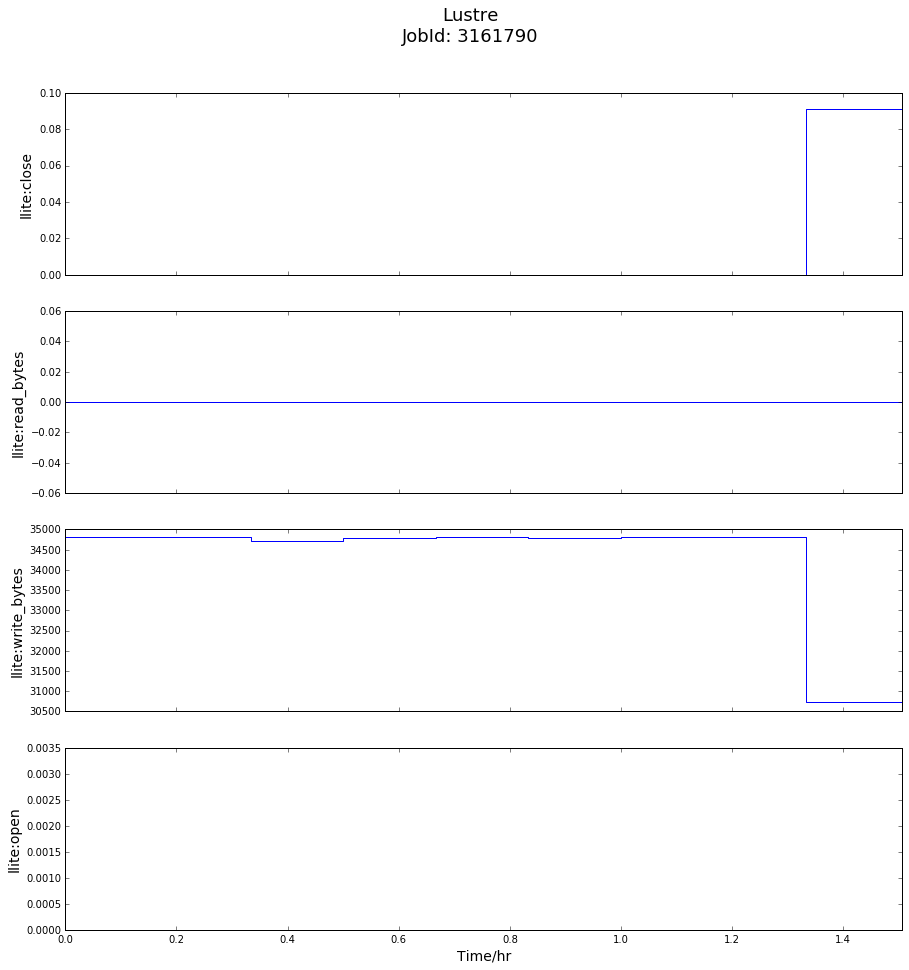

In [21]:
fig, ax = plt.subplots(len(keys), sharex=True, figsize=(15,15))
fig.suptitle('Lustre\nJobId: '+jobid, fontsize=18)
i = -1
for key in keys:
    i += 1
    ax[i].step(combined_dict['Time'][0],combined_dict[key][0])
    ax[i].set_ylabel(key, fontsize=14)
    ax[i].set_xlim(min(combined_dict['Time'][0]),max(combined_dict['Time'][0]))
ax[i].set_xlabel('Time/hr', fontsize=14);

#Block

In [22]:
jobid = '3139904'
with open('pickles1/'+jobid, 'r') as handle:
    data = pickle.load(handle)

hosts, combined_dict = io_info(jobid, data)

In [37]:
term='block'
keys = [i for i in combined_dict.keys() if term in i]
# keys=['block:rd_ios', 'block:wr_ios']
keys

['block:rd_merges',
 'block:wr_sectors',
 'block:rd_ios',
 'block:wr_ios',
 'block:wr_merges',
 'block:rd_sectors']

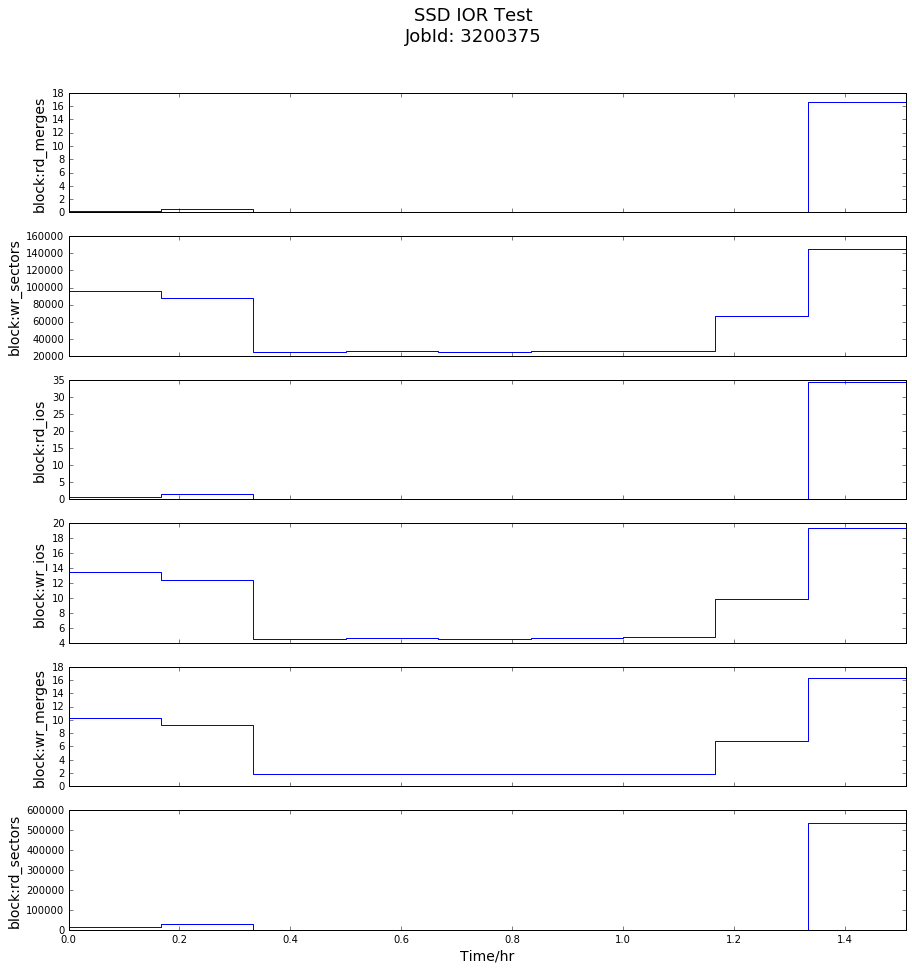

In [42]:
fig, ax = plt.subplots(len(keys), sharex=True, figsize=(15,15))
fig.suptitle('SSD IOR Test\nJobId: '+jobid, fontsize=18)
i = -1
for key in keys:
    i += 1
    ax[i].step(combined_dict['Time'][0],combined_dict[key][0])
    ax[i].set_ylabel(key, fontsize=14)
    ax[i].set_xlim(min(combined_dict['Time'][0]),max(combined_dict['Time'][0]))
ax[i].set_xlabel('Time/hr', fontsize=14);

#NFS

In [25]:
jobid = '3200375'
with open('pickles1/'+jobid, 'r') as handle:
    data = pickle.load(handle)

hosts, combined_dict = io_info(jobid, data)

In [32]:
term='nfs'
# keys = [i for i in combined_dict.keys() if term in i]
keys =['nfs:vfs_readpage',
       'nfs:normal_read',
       'nfs:vfs_writepage',
       'nfs:normal_write',    
]
keys

['nfs:vfs_readpage',
 'nfs:normal_read',
 'nfs:vfs_writepage',
 'nfs:normal_write']

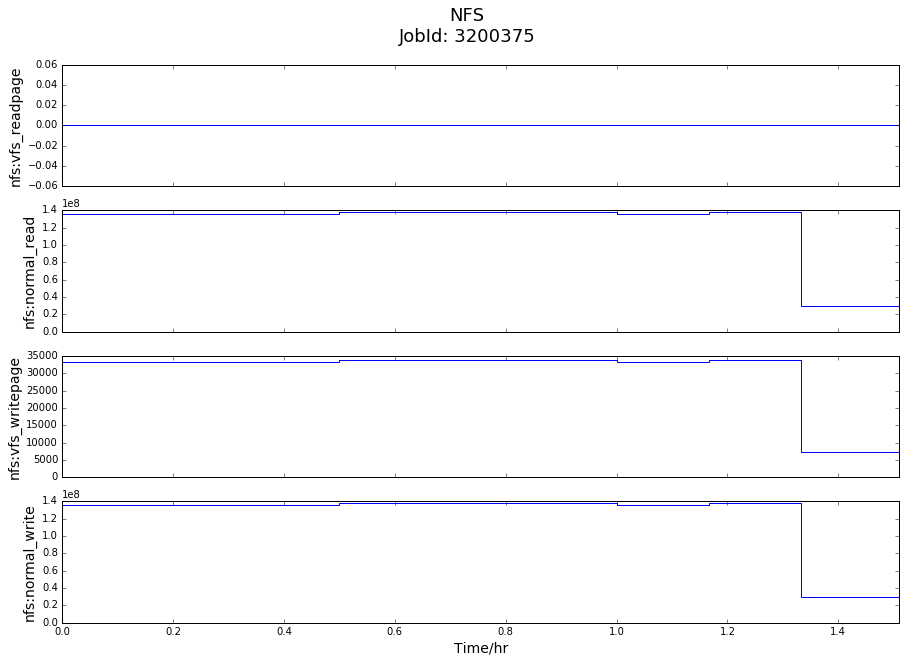

In [36]:
fig, ax = plt.subplots(len(keys), sharex=True, figsize=(15,10))
fig.suptitle('NFS\nJobId: '+jobid, fontsize=18)
i = -1
for key in keys:
    i += 1
    ax[i].step(combined_dict['Time'][0],combined_dict[key][0])
    ax[i].set_ylabel(key, fontsize=14)
    ax[i].set_xlim(min(combined_dict['Time'][0]),max(combined_dict['Time'][0]))
ax[i].set_xlabel('Time/hr', fontsize=14);